# Imports

In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from src.models import NN, CNN, LSTM, RandomForest

DATA_FOLDER = 'data/'

/opt/miniconda3/envs/ml_project_2/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/opt/miniconda3/envs/ml_project_2/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# NN

In [2]:
model = NN(nb_lags=6, lr=1e-2)

######################### Load training data: #########################
train_lags, train_target = torch.load(DATA_FOLDER + 'train_data.pkl')
train_lags, train_target = train_lags.to(model.device), train_target.to(model.device)

######################### Load validation data: #########################
val_lags, val_target = torch.load(DATA_FOLDER + 'val_data.pkl')
val_lags, val_target = val_lags.to(model.device), val_target.to(model.device)

######################### Training: #########################
train = True
if train:
    model.train(train_lags, train_target, num_epochs=1000, val_lags=val_lags, val_target=val_target)

######################### Validation: #########################
#model.load_pretrained_model()
model.test(val_lags, val_target)

Training model: 100%|██████████| 1000/1000 [00:00<00:00, 1245.01 epoch/s]


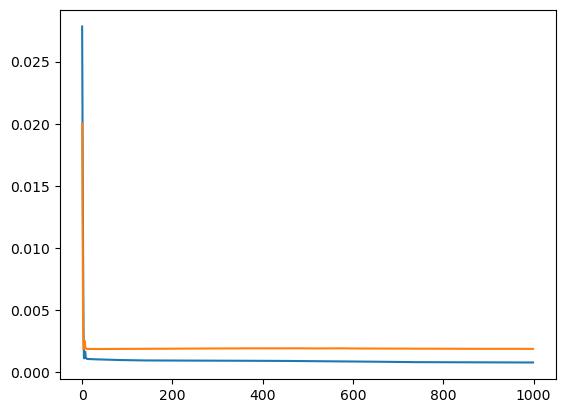

In [3]:
######################### Plot losses: #########################
plt.plot(model.train_losses)
plt.plot(model.val_losses)
plt.show()

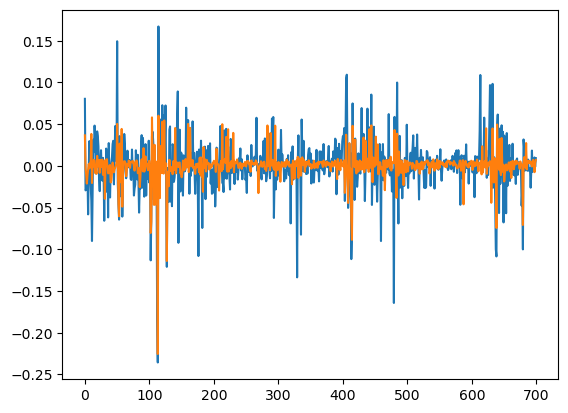

In [4]:
plt.plot(train_target.to('cpu'))
plt.plot(model.forecast(train_lags).to('cpu').detach())
plt.show()

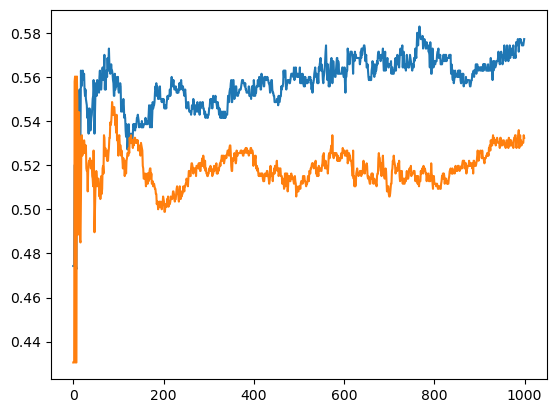

In [5]:
plt.plot(model.train_hit_rates)
plt.plot(model.val_hit_rates)

Training model: 100%|██████████| 1000/1000 [00:00<00:00, 1349.63 epoch/s]


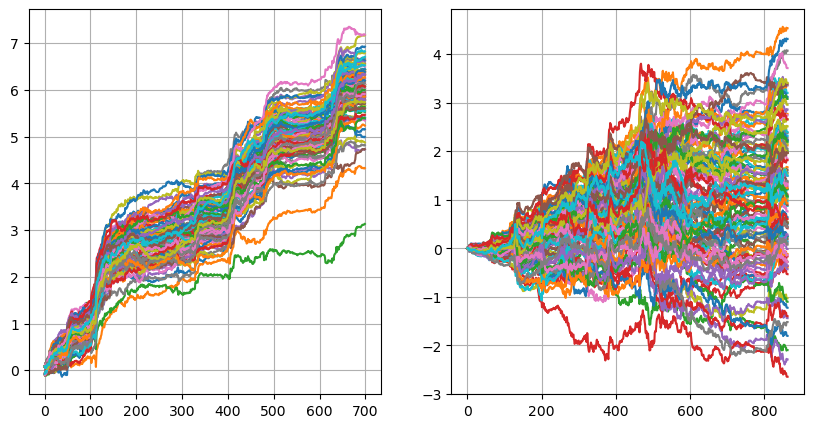

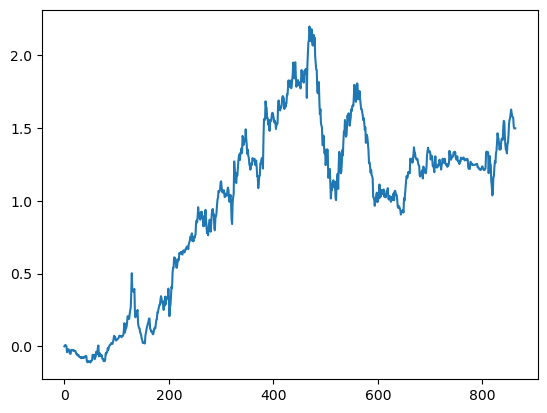

0.5075925913453102
0.7306691491186832
0.5916812421298345


In [14]:
avg_log_returns = np.zeros_like(val_target)
avg_hit_rate = 0
avg_max_dd = 0
avg_sharpe = 0
nb_model = 100

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

for i in range(nb_model):
    model = NN(nb_lags=6, lr=1e-2)
    model.train(train_lags, train_target, num_epochs=1000, val_lags=val_lags, val_target=val_target)
    #model.load_pretrained_model()
    
    model.test(train_lags, train_target)
    ax1.plot(np.cumsum(model.log_returns))
    ax1.grid(True)
    
    model.test(val_lags, val_target)
    ax2.plot(np.cumsum(model.log_returns))
    ax2.grid(True)
    
    avg_log_returns += np.array(model.log_returns)
    avg_hit_rate += model.hit_rate
    avg_max_dd += model.max_dd
    avg_sharpe += model.sharpe


plt.grid(True)
plt.show()

avg_log_returns = avg_log_returns / nb_model
avg_hit_rate = avg_hit_rate / nb_model
avg_max_dd = avg_max_dd / nb_model
avg_sharpe = avg_sharpe / nb_model

plt.plot(np.cumsum(model.log_returns))
plt.show()

print(avg_hit_rate)
print(avg_max_dd)
print(avg_sharpe)

In [15]:
def compute_hit_rate(output, target):
    output, target = torch.Tensor(output), torch.Tensor(target)
    hit_position = (output.sign() * target.sign()) >= 0
    return (hit_position.sum() / len(hit_position)).item()


def compute_max_drawdown(returns):
    returns = pd.Series(returns)
    cumulative = (returns + 1).cumprod()
    peak = cumulative.expanding(min_periods=1).max()
    dd = (cumulative / peak) - 1
    return dd.abs().max()


def compute_sharpe(log_returns, n_periods, rf=0):
    log_returns = pd.Series(log_returns)
    mean = log_returns.mean()
    std = log_returns.std()
    return (n_periods * mean - np.log(1 + rf)) / (std * np.sqrt(n_periods))

In [16]:
print(compute_hit_rate(avg_log_returns, val_target))
print(compute_max_drawdown(avg_log_returns))
print(compute_sharpe(avg_log_returns, n_periods=365))

0.5844907164573669
0.43581229440959823
1.1865851645631302


# CNN

In [2]:
model = CNN(nb_lags=6, lr=1e-2)

######################### Load training data: #########################
train_lags, train_target = torch.load(DATA_FOLDER + 'train_data.pkl')
train_lags, train_target = train_lags.to(model.device), train_target.to(model.device)

######################### Load validation data: #########################
val_lags, val_target = torch.load(DATA_FOLDER + 'val_data.pkl')
val_lags, val_target = val_lags.to(model.device), val_target.to(model.device)

######################### Training: #########################
train = True
if train:
    model.train(train_lags, train_target, num_epochs=35, val_lags=val_lags, val_target=val_target)

######################### Validation: #########################
#model.load_pretrained_model()
model.test(val_lags, val_target)

Training model: 100%|██████████| 35/35 [00:00<00:00, 38.87 epoch/s]


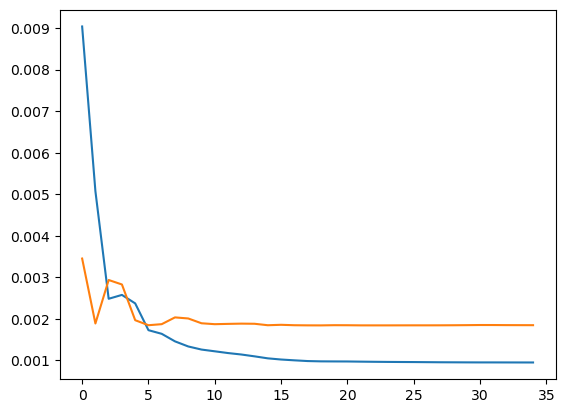

In [3]:
######################### Plot losses: #########################
plt.plot(model.train_losses)
plt.plot(model.val_losses)
plt.show()

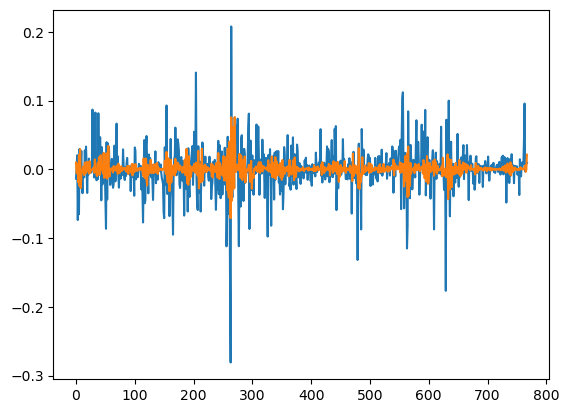

In [4]:
plt.plot(train_target.to('cpu'))
plt.plot(model.forecast(train_lags).to('cpu').detach())
plt.show()

Training model: 100%|██████████| 35/35 [00:00<00:00, 40.25 epoch/s]


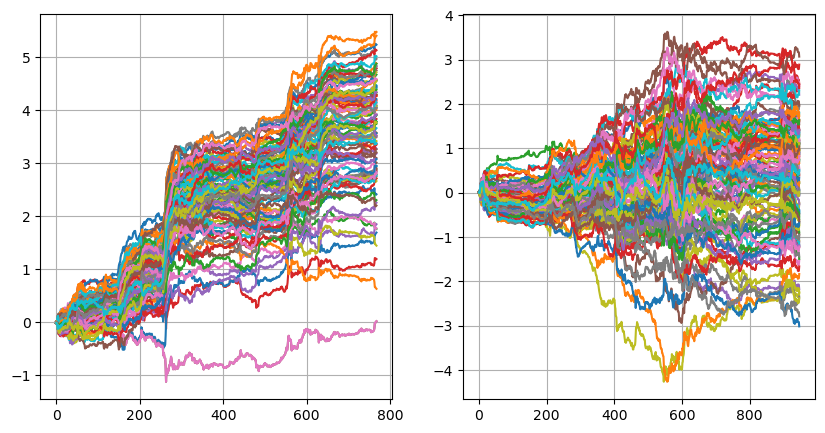

0.507845829129219
0.7806927688644678
0.13829280534509977


In [5]:
avg_hit_rate = 0
avg_max_dd = 0
avg_sharpe = 0
nb_model = 100

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

for i in range(nb_model):
    model = CNN(nb_lags=6, lr=1e-2)
    model.train(train_lags, train_target, num_epochs=35, val_lags=val_lags, val_target=val_target)
    #model.load_pretrained_model()
    
    model.test(train_lags, train_target)
    ax1.plot(np.cumsum(model.log_returns))
    ax1.grid(True)
    
    model.test(val_lags, val_target)
    ax2.plot(np.cumsum(model.log_returns))
    ax2.grid(True)
    
    avg_hit_rate += model.hit_rate
    avg_max_dd += model.max_dd
    avg_sharpe += model.sharpe


plt.grid(True)
plt.show()

avg_hit_rate = avg_hit_rate / nb_model
avg_max_dd = avg_max_dd / nb_model
avg_sharpe = avg_sharpe / nb_model

print(avg_hit_rate)
print(avg_max_dd)
print(avg_sharpe)

# LSTM

In [3]:
model = LSTM(nb_lags=6, lr=1e-2)

######################### Load training data: #########################
train_lags, train_target = torch.load(DATA_FOLDER + 'train_data.pkl')
train_lags, train_target = train_lags.to(model.device), train_target.to(model.device)

######################### Load validation data: #########################
val_lags, val_target = torch.load(DATA_FOLDER + 'val_data.pkl')
val_lags, val_target = val_lags.to(model.device), val_target.to(model.device)

######################### Training: #########################
train = True
if train:
    model.train(train_lags, train_target, num_epochs=100, val_lags=val_lags, val_target=val_target)

######################### Validation: #########################
#model.load_pretrained_model()
model.test(val_lags, val_target)

Training model: 100%|██████████| 100/100 [00:00<00:00, 114.89 epoch/s]


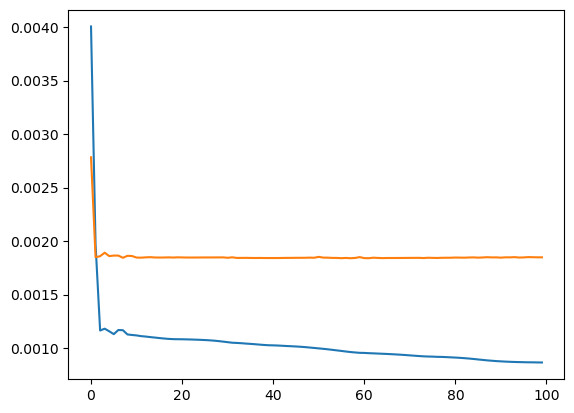

In [4]:
######################### Plot losses: #########################
plt.plot(model.train_losses)
plt.plot(model.val_losses)
plt.show()

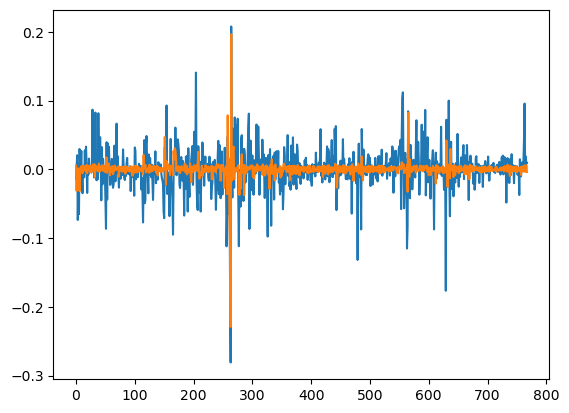

In [5]:
plt.plot(train_target.to('cpu'))
plt.plot(model.forecast(train_lags).to('cpu').detach())
plt.show()

Training model: 100%|██████████| 35/35 [00:00<00:00, 118.45 epoch/s]


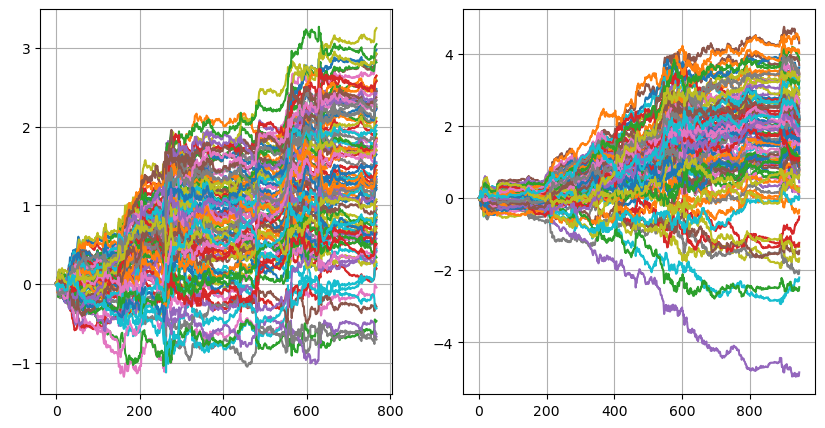

0.5071488904953003
0.6716330732135961
0.7428174776185921


In [6]:
avg_hit_rate = 0
avg_max_dd = 0
avg_sharpe = 0
nb_model = 100

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

for i in range(nb_model):
    model = LSTM(nb_lags=6, lr=1e-2)
    model.train(train_lags, train_target, num_epochs=35, val_lags=val_lags, val_target=val_target)
    #model.load_pretrained_model()
    
    model.test(train_lags, train_target)
    ax1.plot(np.cumsum(model.log_returns))
    ax1.grid(True)
    
    model.test(val_lags, val_target)
    ax2.plot(np.cumsum(model.log_returns))
    ax2.grid(True)
    
    avg_hit_rate += model.hit_rate
    avg_max_dd += model.max_dd
    avg_sharpe += model.sharpe


plt.grid(True)
plt.show()

avg_hit_rate = avg_hit_rate / nb_model
avg_max_dd = avg_max_dd / nb_model
avg_sharpe = avg_sharpe / nb_model

print(avg_hit_rate)
print(avg_max_dd)
print(avg_sharpe)

# Number of parameters

In [67]:
model = NN(nb_lags=6, lr=1e-2)
print("NN: ", sum(p.numel() for p in model.parameters() if p.requires_grad))

model = CNN(nb_lags=6, lr=1e-2)
print("CNN: ", sum(p.numel() for p in model.parameters() if p.requires_grad))

model = LSTM(nb_lags=6, lr=1e-2)
print("LSTM: ", sum(p.numel() for p in model.parameters() if p.requires_grad))

NN:  67
CNN:  69
LSTM:  91


# Random forest

In [7]:
model = RandomForest(n_estimators=100)

######################### Load training data: #########################
train_lags, train_target = torch.load(DATA_FOLDER + 'train_data.pkl')
train_lags, train_target = train_lags.numpy(), train_target.numpy()

######################### Load validation data: #########################
val_lags, val_target = torch.load(DATA_FOLDER + 'val_data.pkl')
val_lags, val_target = val_lags.numpy(), val_target.numpy()

In [8]:
######################### Training: #########################
train = True
if train:
    model.train(train_lags, train_target)

######################### Validation: #########################
#model.load_pretrained_model()
model.test(val_lags, val_target)

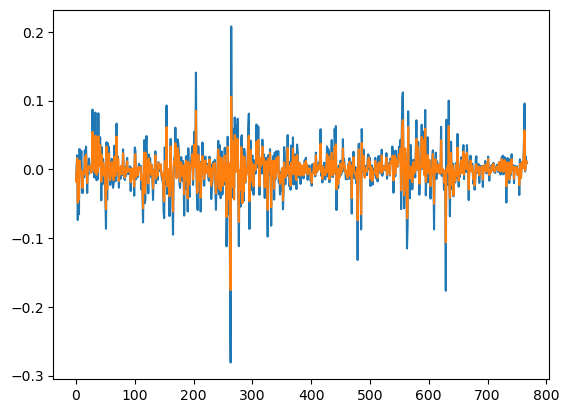

In [9]:
plt.plot(train_target)
plt.plot(model.predict(train_lags))
plt.show()

100%|██████████| 10/10 [00:03<00:00,  2.81it/s]


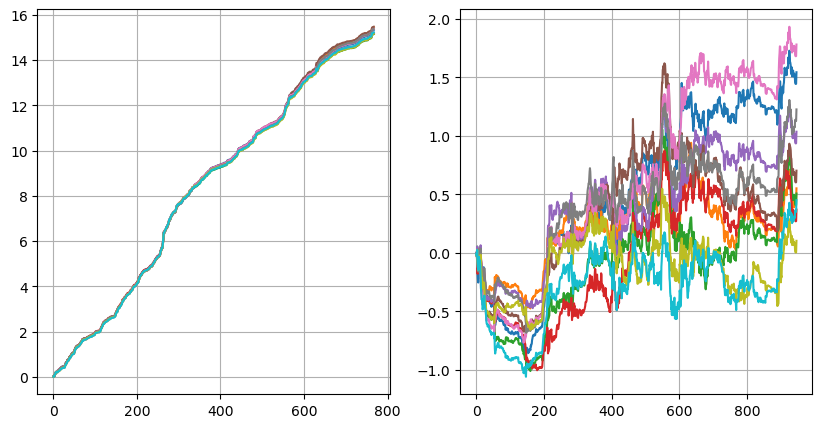

0.5053854286670685
0.6998177162864361
0.387909756281733


In [10]:
avg_hit_rate = 0
avg_max_dd = 0
avg_sharpe = 0
nb_model = 10

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

for i in tqdm(range(nb_model)):
    model = RandomForest(n_estimators=100)
    model.train(train_lags, train_target)
    #model.load_pretrained_model()
    
    model.test(train_lags, train_target)
    ax1.plot(np.cumsum(model.log_returns))
    ax1.grid(True)
    
    model.test(val_lags, val_target)
    ax2.plot(np.cumsum(model.log_returns))
    ax2.grid(True)
    
    avg_hit_rate += model.hit_rate
    avg_max_dd += model.max_dd
    avg_sharpe += model.sharpe


plt.grid(True)
plt.show()

avg_hit_rate = avg_hit_rate / nb_model
avg_max_dd = avg_max_dd / nb_model
avg_sharpe = avg_sharpe / nb_model

print(avg_hit_rate)
print(avg_max_dd)
print(avg_sharpe)